Lets do some machine learning to classify different objects (trees, water, fields, etc.)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import GDAL, NumPy, and matplotlib
from osgeo import gdal_array
import gdal
import numpy as np
import matplotlib.pyplot as plt
import cv2

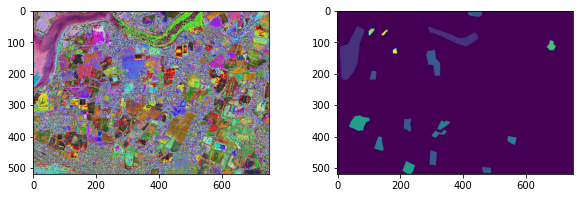

In [3]:
%matplotlib inline  

directory = '/content/drive/MyDrive/GIS_tutorials/2_python_main_gis_functions/day2_data_package/'

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read in raster image of training areas
img_ds = gdal.Open('South_coast.tif', gdal.GA_ReadOnly)
training_ds = gdal.Open('training_mask.gtif', gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
training = training_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)


#### show the data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.imshow(img.astype(np.uint8))

plt.subplot(1, 2, 2)
plt.imshow(training)

plt.show()

In [9]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (training > 0).sum()
print ("number of samples:", n_samples) 

# "X" array containing our features, and a "y" array containing our labels

# These will have n_samples rows

X = img[training > 0]
y = training[training > 0]

print('Our X array is', X.shape)
print('Our y array is', y.shape)

number of samples: 21944
Our X array is (21944, 3)
Our y array is (21944,)


In [10]:
## import random forest algorithm
## https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 50 trees
clf = RandomForestClassifier(n_estimators=50, oob_score=True)

# Fit our model to training data
clf = clf.fit(X, y)

## http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
##"Out-of-Bag" (OOB) prediction score:
print("Prediction accuracy is ", clf.oob_score_*100, "%")

Prediction accuracy is  96.74626321545753 %


In [11]:
# reshape into long 2d array (nrow * ncol, nband) for classification
X = img.reshape((-1,img.shape[2])) ## for example in 13 bands X1 = img.reshape((-1,13))
print(X.shape)

# Now predict for each pixel
class_prediction = clf.predict(X)

# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)

### what does our new raster look like?

(389769, 3)


<class 'numpy.ndarray'>

7


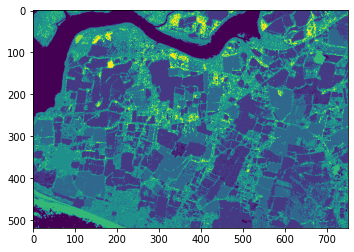

In [12]:
# plot using matplotlib

n = class_prediction.max()
print(type(class_prediction)) ### remember if its a numpy array we can convert back to geotiff!
print()
print(n)

plt.imshow(class_prediction)
plt.show()

In [14]:
## write out to tiff

format = "GTiff"
driver = gdal.GetDriverByName(format)

outDataRaster = driver.CreateCopy('classified_model.gtif', training_ds, 0)
outDataRaster.GetRasterBand(1).WriteArray(class_prediction)

outDataRaster.FlushCache()
del outDataRaster

In [16]:
### remember to build the verify raster data

training_verify = gdal.Open('training_verify_data.gtif', gdal.GA_ReadOnly)
training_v = training_verify.GetRasterBand(1).ReadAsArray().astype(np.uint8)

y1 = training_v[training_v > 0]
X1 = img[training_v > 0]

print(y1.shape)
print(X1.shape)

(5807,)
(5807, 3)


In [17]:
## import metrics for model estimation
from sklearn import metrics

target_names = ['Water', 'Field', 'Bare Earth', 'Urban', 'Cloud', 'Sand', 'Trees']

print("Classification report:\n%s" % metrics.classification_report(y1, clf.predict(X1),target_names=target_names))

print("Classification accuracy: %f" % metrics.accuracy_score(y1, clf.predict(X1)))



Classification report:
              precision    recall  f1-score   support

       Water       0.99      1.00      1.00      1501
       Field       0.93      0.99      0.96      1256
  Bare Earth       0.97      0.76      0.85      1102
       Urban       0.72      0.88      0.79      1410
       Cloud       0.78      0.99      0.88       127
        Sand       0.72      0.16      0.26       181
       Trees       0.77      0.56      0.65       230

    accuracy                           0.88      5807
   macro avg       0.84      0.76      0.77      5807
weighted avg       0.89      0.88      0.87      5807

Classification accuracy: 0.880317


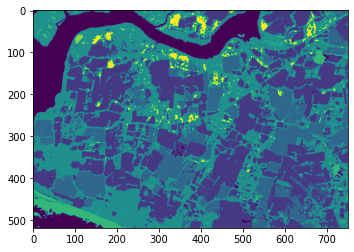

In [18]:
### Can it be improved?
from scipy import ndimage

med = ndimage.median_filter(class_prediction, 3)    ### 3x3 median filter

plt.imshow(med)
plt.show()

In [19]:
target_names = ['Water', 'Field', 'Bare Earth', 'Urban', 'Cloud', 'Sand', 'Trees']

## now rebuild the classification for the model... using median fit
y1 = training_v[training_v > 0]
X1 = med[training_v > 0]

print("Classification report:\n%s" % metrics.classification_report(y1, X1,target_names=target_names))

print("Classification accuracy: %f" % metrics.accuracy_score(y1, X1))


Classification report:
              precision    recall  f1-score   support

       Water       1.00      1.00      1.00      1501
       Field       1.00      1.00      1.00      1256
  Bare Earth       1.00      0.77      0.87      1102
       Urban       0.73      1.00      0.84      1410
       Cloud       0.98      0.99      0.99       127
        Sand       0.65      0.06      0.11       181
       Trees       0.99      0.58      0.73       230

    accuracy                           0.91      5807
   macro avg       0.91      0.77      0.79      5807
weighted avg       0.92      0.91      0.90      5807

Classification accuracy: 0.909936


write this raster out to compare

In [21]:
format = "GTiff"
driver = gdal.GetDriverByName(format)

outDataRaster = driver.CreateCopy('classified_model_2.gtif', training_ds,0)
outDataRaster.GetRasterBand(1).WriteArray(med)

outDataRaster.FlushCache()
del outDataRaster